In [18]:
import torch
import torch.nn as nn
from torchvision.models import ResNet34_Weights
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Resize, CenterCrop
from torchvision.transforms import v2
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [19]:
# function using model to extract feature + label tensors from dataset
def extract_features(model, loader, device):
    # set model to evaluation mode
    model.eval()
    
    features, labels = [], []
    
    # gradients not needed for inference
    with torch.no_grad():
        for image, label in tqdm(loader, desc="Extracting features"):
            # Forward pass through the model
            image = image.to(device)
            label = label.to(device)
            features_batch = model(image)
            # Flatten the features
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch.cpu())
            labels.append(label)
    
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

# function to create model pretrained on ImageNet only
def ImageNetModel(device):
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    model = model.to(device)
    return model

# function to find and plot KL divergence for a range of perplexity values
def find_perplexity(features, min_perplexity, max_perplexity, step, num_components):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    # array of perplexity values to test
    perplexity = np.arange(min_perplexity, max_perplexity, step)

    divergence = []
    
    # find the KL divergence for each perplexity value
    for i in perplexity:
        model = TSNE(n_components=num_components, init="pca", perplexity=i)
        reduced = model.fit_transform(features_np)
        divergence.append(model.kl_divergence_)
    
    # plot divergence
    fig = px.line(x=perplexity, y=divergence, markers=True)
    fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
    fig.update_traces(line_color="red", line_width=1)
    fig.show()
    
# function to perform tsne on features extracted and visualize results
def perform_tsne(features, perplexity, labels, title):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    labels = labels.cpu()
    
    # perform tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # plot results
    fig, ax = plt.subplots()
    scatter = ax.scatter(x=features_tsne[:, 0], y=features_tsne[:, 1], c=labels, alpha=0.3)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend1)
    plt.title(title)
    plt.show()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# load custom model
model1 = resnet34(num_classes=3).to(device)
model1.load_state_dict(torch.load("./model.pth", map_location=device))

# load ImageNet model
model2 = ImageNetModel(device)

models = {
    # remove final classification layer in each model
    "Custom Model": nn.Sequential(*list(model1.children())[:-1]),
    "ImageNet Model": nn.Sequential(*list(model2.children())[:-1])
}

In [22]:
# define transformations according to ImageNet preprocessing
ImageNet_transform = v2.Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define transformations according to custom model's preprocessing
custom_transform = v2.Compose([
    ToTensor(), 
    Normalize([0.7621, 0.5239, 0.7111], [0.0066, 0.0096, 0.0063])
])

# load transformed Dataset 2 and 3 for each model
data_loaders = {
    "Custom Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='./Prostate Cancer', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='./Animal Faces', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4)
    },
    "ImageNet Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='./Prostate Cancer', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='./Animal Faces', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4)
    },
}

Extracting features: 100%|█████████████████████████████████████████████████████████████| 94/94 [01:02<00:00,  1.50it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.003s...
[t-SNE] Computed neighbors for 6000 samples in 0.441s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.716010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.792969
[t-SNE] KL divergence after 1000 iterations: 1.410142


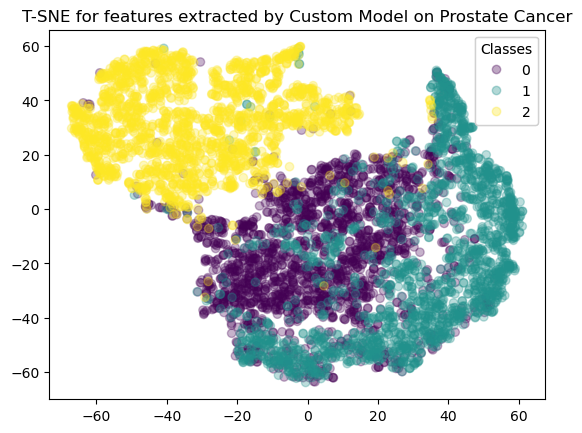

Extracting features: 100%|█████████████████████████████████████████████████████████████| 94/94 [06:46<00:00,  4.32s/it]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.002s...
[t-SNE] Computed neighbors for 6000 samples in 0.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 4.137728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.771744
[t-SNE] KL divergence after 1000 iterations: 1.342368


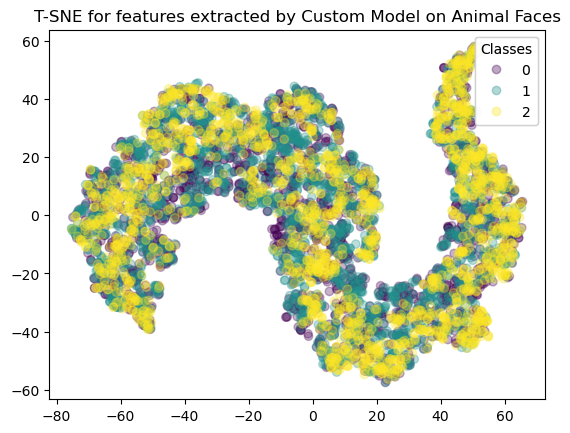

Extracting features: 100%|█████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.05it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.003s...
[t-SNE] Computed neighbors for 6000 samples in 0.432s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 3.770521
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.712112
[t-SNE] KL divergence after 1000 iterations: 2.216349


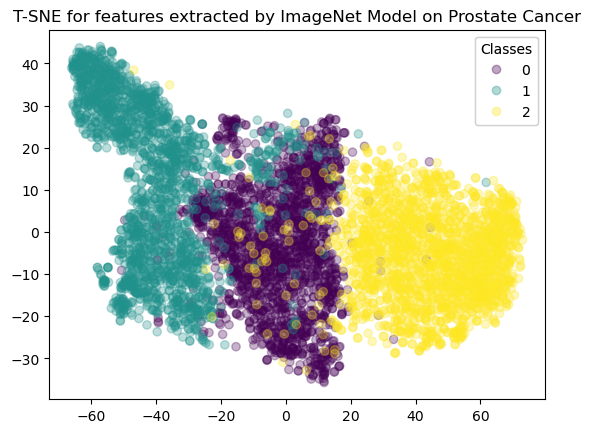

Extracting features: 100%|█████████████████████████████████████████████████████████████| 94/94 [00:30<00:00,  3.10it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.002s...
[t-SNE] Computed neighbors for 6000 samples in 0.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 3.773029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.560486
[t-SNE] KL divergence after 1000 iterations: 1.382903


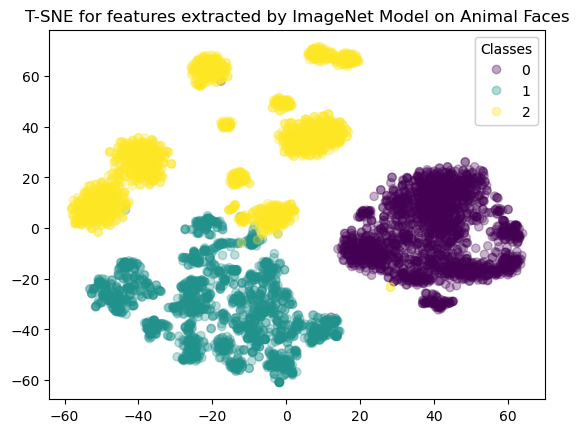

In [23]:
# apply feature extraction then tsne for 4 scenarios
# custom model on Dataset 2, custom model on Dataset 3
# ImageNet model on Dataset 2, ImageNet model on Dataset 3
for model_name, model in models.items():
    for dataset_name, dataloader in data_loaders[model_name].items():
        features, labels = extract_features(model, dataloader, device)
        perform_tsne(features, 35, labels, f"T-SNE for features extracted by {model_name} on {dataset_name}")